# Demo for AMS22

This was developed and tested on the Google Pangeo Deployment (more infos [here](https://pangeo.io/cloud.html#)).

In [70]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 15, 8
%config InlineBackend.figure_format = 'retina'

## Request Dask Cluster for parallel processing of the data

This notebook server does not have enough cores to efficiently work with the data, so lets get a dask cluster set up first:

In [2]:
from dask_gateway import GatewayCluster
from distributed import Client

cluster = GatewayCluster()
cluster.scale(30)
client = Client(cluster)
client

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask_gateway/client.py:21: FutureWarning: format_bytes is deprecated and will be removed in a future release. Please use dask.utils.format_bytes instead.
  from distributed.utils import LoopRunner, format_bytes


Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.e37d2bd3052d4271afce268df5247228/status,


## Load and clean the data

For this example we use a catalog of CMIP6 zarr files, maintained by the Pangeo Project, and hosted publicly on GCS. For more info on the pangeo CMIP6 data click [here](https://pangeo-data.github.io/pangeo-cmip6-cloud/).

This example uses the custom intake-esm catalog provided, but all functions shown here can be applied to an xarray dataset directly.

In [3]:
import intake
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")

We are only using a few selected models (and members) for the sake of time. But there are a lot more. Feel free to change the cell below and experiment.

In [63]:
# This function is the 'all-in-one' cleaning component of cmip6_preprocessing
from cmip6_preprocessing.preprocessing import combined_preprocessing

selected_models = [
    "IPSL-CM6A-LR",
    "ACCESS-ESM1-5",
    "GFDL-ESM4",
    "CESM2",
    "MPI-ESM1-2-LR",
    "TaiESM1",
    "CanESM5",
    "MIROC-ES2L",
    "EC-Earth3",
    "CMCC-ESM2",
]

query = dict(
    experiment_id=["historical", "ssp585"],
    source_id=selected_models,
    grid_label='gn',
)

kwargs = dict(
    zarr_kwargs={"consolidated": True, "use_cftime": True},
    preprocess=combined_preprocessing, # This is the only modification needed
    aggregate=False,
    storage_options={'anon':True},
    
)

# load two dataset dictionaries: One for the surface temperature and another
# for the horizontal grid area

dset_dict = col.search(
    variable_id="tos",
    member_id=["r4i1p1f1", "r3i1p1f1", "r5i1p1f1","r2i1p1f1","r1i1p1f1"],
    table_id="Omon",
    **query
).to_dataset_dict(**kwargs)

metric_dict = col.search(
    variable_id="areacello",
    **query
).to_dataset_dict(**kwargs)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


## Postprocessing - Combining datasets for final analysis

Now we will add the metrics (horizontal cell area) and concatenate the members of each model into a dataset with an additional `member_id` dimension. 

In [64]:
from cmip6_preprocessing.postprocessing import match_metrics, concat_members

# cut runs that are running past 2100 (can lead to dask chunking issues)
dset_dict_cut = {k:ds.sel(time=slice(None,'2100')) for k,ds in dset_dict.items()}
#combine with matching metrics 
# (see https://cmip6-preprocessing.readthedocs.io/en/latest/postprocessing.html#Handling-grid-metrics-in-CMIP6)
dset_dict_w_metrics = match_metrics(dset_dict_cut, metric_dict, ['areacello'])
# concatenate members for each source_id and experiment_id 
# (see https://cmip6-preprocessing.readthedocs.io/en/latest/postprocessing.html#Postprocessing)
dset_dict_combined = concat_concat_members(dset_dict_w_metrics)

In [66]:
dset_dict_combined['CESM2.gn.historical.Omon']

<xarray.Dataset>
Dimensions:        (y: 384, x: 320, vertex: 4, time: 1980, bnds: 2, member_id: 5)
Coordinates: (12/13)
    lat            (y, x) float64 -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
    lat_verticies  (y, x, vertex) float32 -79.49 -78.95 -78.95 ... 72.41 71.96
    lon            (y, x) float64 320.6 321.7 322.8 323.9 ... 318.9 319.4 319.8
    lon_verticies  (y, x, vertex) float32 320.0 320.0 321.1 ... 320.0 320.0
  * y              (y) int32 1 2 3 4 5 6 7 8 ... 377 378 379 380 381 382 383 384
  * x              (x) int32 1 2 3 4 5 6 7 8 ... 313 314 315 316 317 318 319 320
    ...             ...
    time_bounds    (time, bnds) object 1850-01-01 02:00:00.000003 ... 2015-01...
  * vertex         (vertex) int64 0 1 2 3
  * bnds           (bnds) int64 0 1
    lon_bounds     (bnds, y, x) float32 320.0 321.1 322.2 ... 319.1 319.6 320.0
    lat_bounds     (bnds, y, x) float32 -79.49 -79.49 -79.49 ... 72.42 72.41
    areacello      (y, x) float32 1.125e+09 1.125e+09 ... 7.431e+08 7.432e+08
Dimensions without coordinates: member_id
Data variables:
    tos            (member_id, time, y, x) float32 dask.array<chunksize=(1, 403, 384, 320), meta=np.ndarray>
Attributes: (12/40)
    Conventions:           CF-1.7 CMIP-6.2
    activity_id:           CMIP
    branch_method:         standard
    branch_time_in_child:  674885.0
    contact:               cesm_cmip6@ucar.edu
    data_specs_version:    01.00.29
    ...                    ...
    table_id:              Omon
    variable_id:           tos
    variant_info:          CMIP6 20th century experiments (1850-2014) with CA...
    status:                2019-10-25;created;by nhn2@columbia.edu
    version_id:            v20190308
    intake_esm_varname:    None

CPU times: user 4.5 s, sys: 85 ms, total: 4.59 s
Wall time: 1min 10s


Text(0, 0.5, 'Global Average Sea Surface Temperature')

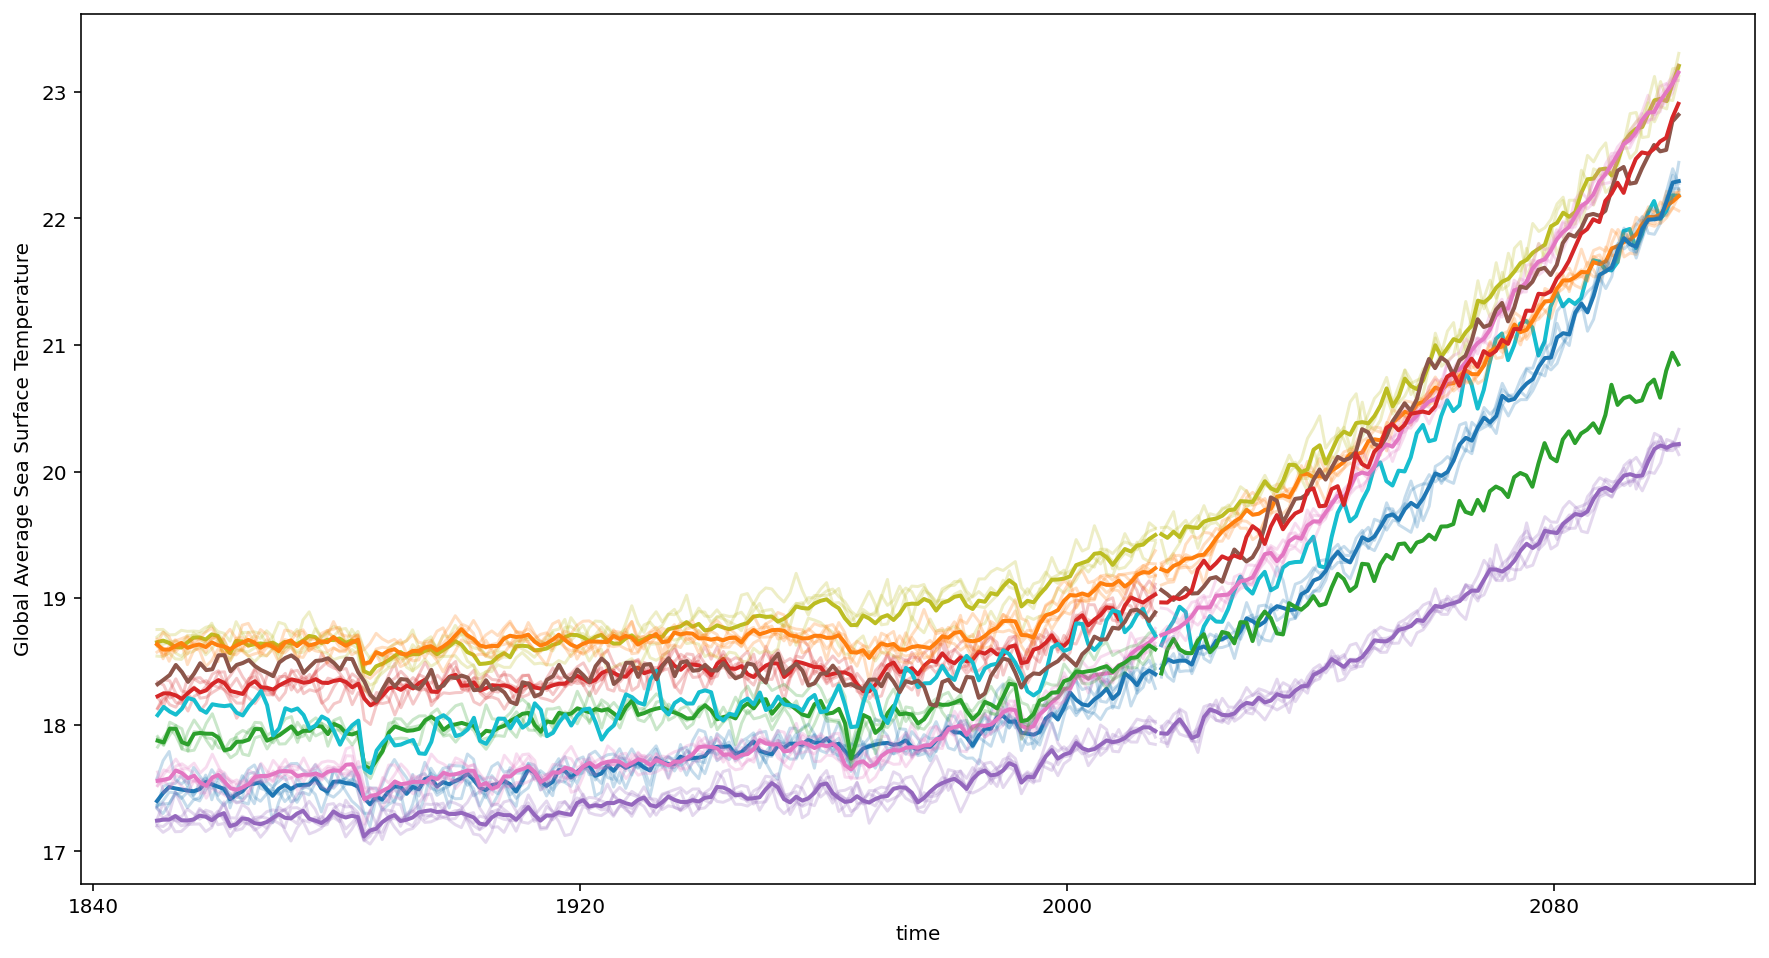

In [72]:
%%time
import matplotlib.pyplot as plt

color_dict = {k:f"C{ki}" for ki, k in enumerate(selected_models)}

plt.figure()
for ni, (name, ds) in enumerate(dset_dict_combined.items()):
    
    # Weighted average of surface ocean temperatures
    sst = ds.tos.weighted(ds.areacello.fillna(0)).mean(['x','y'])
    
    # annual averages
    sst = sst.coarsen(time=12).mean()
    
    ### Plotting ###
    color = color_dict[ds.source_id]
    # plot single members
    sst.plot(
        hue='member_id',
        color=color,
        add_legend=False,
        alpha=0.25
    )
    # plot member average
    sst.mean('member_id').plot(
        linewidth=2,
        color=color,
        add_legend=False,
        label=name
    )
    
plt.ylabel('Global Average Sea Surface Temperature')

## How much data did we processed just now?

In [69]:
total_size = []
for ni, (name, ds) in enumerate(dset_dict_combined.items()):
    sst_size = ds.tos.nbytes
    area_size = ds.areacello.nbytes
    total_size.append(sst_size+area_size)
print(f'We just crunched through {sum(total_size)/1e9}GB of data')

We just crunched through 47.313962112GB of data


This means that we were able to process around 40+GB in about a minute. Contrast that with the 'download and analyze' model:

>Assuming a fast internet connection with 20MB/s throughput, downloading this data alone would have taken 30+ minutes.